In [1]:
import torch
import numpy as np
import pickle


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import gym_sin
from gym import spaces

from active_learning.recurrent import RL2
from task.GuassianTaskGenerator import GaussianTaskGenerator

In [2]:
def get_const_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[-10], [5]], dtype=torch.float32) for _ in range(num_test_processes)]
        
    mean = -5
    std = 15
    
    for idx in range(50):
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test

def get_linear_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    for idx in range(50):
        std = 15
        mean = 30 - idx
        
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test

def get_phase_task_sequence(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[-5], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    for idx in range(50):
        if idx < 15:
            std = 15
            mean = 0
        elif idx < 30:
            std = 15
            mean = 10
        else:
            std = 15
            mean = 0
            
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test

def get_abrupt_and_smooth(alpha, n_restarts, num_test_processes):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(2):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    test_kwargs = []
    init_prior_test = [torch.tensor([[-30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    for idx in range(80):
        if idx < 15:
            std = 15
            mean = -30
        elif idx < 50:
            std = 15
            mean = -20 + (idx - 15)
        else:
            std = 15
            mean = -20 + 50 - 15 

            
        test_kwargs.append({'amplitude': 1,
                            'mean': mean,
                            'std': std,
                            'noise_std': 0.001,
                            'scale_reward': False})

    return gp_list, test_kwargs, init_prior_test


In [3]:
env_name = "gauss-v0"

action_space = spaces.Box(low=np.array([-1]), high=np.array([1]))
latent_dim = 1

x_min = -100
x_max = 100

min_mean = -40
max_mean = 40

prior_mu_min = -10
prior_mu_max = 10
prior_std_min = 1
prior_std_max = 10

std = 15
amplitude=1

device = "cpu"

task_generator = GaussianTaskGenerator(x_min, x_max, min_mean, max_mean,
                 prior_mu_min, prior_mu_max, prior_std_min, prior_std_max, std, amplitude)
fam = task_generator.create_task_family(n_tasks=5000, n_batches=1, test_perc=0, batch_size=1)

In [4]:
hidden_size = 32
use_elu = True
clip_param = 0.2
ppo_epoch = 4 
num_mini_batch = 8
value_loss_coef = 0.5
entropy_coef = 0.
lr = 0.0001
eps = 1e-6
max_grad_norm = 0.5

use_obs_env = False
obs_shape = (2,)
num_processes = 32
gamma = 1
device = "cpu"
num_steps = 150
action_dim = 1
use_gae = False
gae_lambda = 0.95
use_proper_time_limits = False

agent = RL2(hidden_size, use_elu, clip_param, ppo_epoch, num_mini_batch, value_loss_coef,
                 entropy_coef, lr, eps, max_grad_norm, action_space, obs_shape, use_obs_env,
                 num_processes, gamma, device, num_steps, action_dim, use_gae, gae_lambda,
                 use_proper_time_limits)

In [5]:
n_iter = 5000
env_name = 'gauss-v0'
seed = 0
eval_interval = 20
num_test_processes = 1
num_random_task_to_eval = 32

test_kwargs_sequences = [get_const_task_sequence(0.25, 1, 1)[1]]

In [7]:
eval_list, test_list = agent.train(n_iter, env_name, seed, task_generator,
            eval_interval, num_test_processes, num_random_task_to_eval,
            test_kwargs_sequences=test_kwargs_sequences, log_dir=".", verbose=True)

Iteration 0 / 5000
Evaluation using 32 tasks. Mean reward: 15.670923062499998
Iteration 20 / 5000
Evaluation using 32 tasks. Mean reward: 14.608395156250001
Iteration 40 / 5000
Evaluation using 32 tasks. Mean reward: 15.230333593749998
Iteration 60 / 5000
Evaluation using 32 tasks. Mean reward: 16.773078062499998
Iteration 80 / 5000
Evaluation using 32 tasks. Mean reward: 16.14672053125
Iteration 100 / 5000
Evaluation using 32 tasks. Mean reward: 16.49008359375
Iteration 120 / 5000
Evaluation using 32 tasks. Mean reward: 16.240571125
Iteration 140 / 5000
Evaluation using 32 tasks. Mean reward: 16.36997071875
Iteration 160 / 5000
Evaluation using 32 tasks. Mean reward: 16.21297646875
Iteration 180 / 5000
Evaluation using 32 tasks. Mean reward: 15.97599171875
Iteration 200 / 5000
Evaluation using 32 tasks. Mean reward: 17.0086595
Iteration 220 / 5000
Evaluation using 32 tasks. Mean reward: 17.51644803125
Iteration 240 / 5000
Evaluation using 32 tasks. Mean reward: 18.59178071875
Iteratio

Evaluation using 32 tasks. Mean reward: 48.57933953125
Iteration 2140 / 5000
Evaluation using 32 tasks. Mean reward: 48.77452446875
Iteration 2160 / 5000
Evaluation using 32 tasks. Mean reward: 45.80615190625
Iteration 2180 / 5000
Evaluation using 32 tasks. Mean reward: 45.7687906875
Iteration 2200 / 5000
Evaluation using 32 tasks. Mean reward: 47.30917303125
Iteration 2220 / 5000
Evaluation using 32 tasks. Mean reward: 44.666329968750006
Iteration 2240 / 5000
Evaluation using 32 tasks. Mean reward: 51.202162875
Iteration 2260 / 5000
Evaluation using 32 tasks. Mean reward: 46.778560562500004
Iteration 2280 / 5000
Evaluation using 32 tasks. Mean reward: 37.2735596875
Iteration 2300 / 5000
Evaluation using 32 tasks. Mean reward: 49.693194625
Iteration 2320 / 5000
Evaluation using 32 tasks. Mean reward: 49.9084514375
Iteration 2340 / 5000
Evaluation using 32 tasks. Mean reward: 50.341419218750005
Iteration 2360 / 5000
Evaluation using 32 tasks. Mean reward: 47.493546656250004
Iteration 23

Iteration 4240 / 5000
Evaluation using 32 tasks. Mean reward: 82.8582401875
Iteration 4260 / 5000
Evaluation using 32 tasks. Mean reward: 85.78236415625
Iteration 4280 / 5000
Evaluation using 32 tasks. Mean reward: 62.74435503125
Iteration 4300 / 5000
Evaluation using 32 tasks. Mean reward: 84.06036178125
Iteration 4320 / 5000
Evaluation using 32 tasks. Mean reward: 76.94450796875
Iteration 4340 / 5000
Evaluation using 32 tasks. Mean reward: 91.49369375
Iteration 4360 / 5000
Evaluation using 32 tasks. Mean reward: 79.60018740625
Iteration 4380 / 5000
Evaluation using 32 tasks. Mean reward: 86.76140784374999
Iteration 4400 / 5000
Evaluation using 32 tasks. Mean reward: 91.88433984375
Iteration 4420 / 5000
Evaluation using 32 tasks. Mean reward: 78.46716821875
Iteration 4440 / 5000
Evaluation using 32 tasks. Mean reward: 88.92814209375
Iteration 4460 / 5000
Evaluation using 32 tasks. Mean reward: 71.921971625
Iteration 4480 / 5000
Evaluation using 32 tasks. Mean reward: 79.671879625
Iter

In [8]:
eval_list_2, test_list_2 = agent.train(2000, env_name, seed, task_generator,
            eval_interval, num_test_processes, num_random_task_to_eval,
            test_kwargs_sequences=test_kwargs_sequences, log_dir=".", verbose=True)

Iteration 0 / 2000
Evaluation using 32 tasks. Mean reward: 8.649953531249999
Iteration 20 / 2000
Evaluation using 32 tasks. Mean reward: 15.64852025
Iteration 40 / 2000
Evaluation using 32 tasks. Mean reward: 12.05758978125
Iteration 60 / 2000
Evaluation using 32 tasks. Mean reward: 31.2907761875
Iteration 80 / 2000
Evaluation using 32 tasks. Mean reward: 25.70844609375
Iteration 100 / 2000
Evaluation using 32 tasks. Mean reward: 25.87686134375
Iteration 120 / 2000
Evaluation using 32 tasks. Mean reward: 39.09228834375
Iteration 140 / 2000
Evaluation using 32 tasks. Mean reward: 34.32307734375
Iteration 160 / 2000
Evaluation using 32 tasks. Mean reward: 38.6640325
Iteration 180 / 2000
Evaluation using 32 tasks. Mean reward: 51.284565
Iteration 200 / 2000
Evaluation using 32 tasks. Mean reward: 44.82142221875
Iteration 220 / 2000
Evaluation using 32 tasks. Mean reward: 41.5919663125
Iteration 240 / 2000
Evaluation using 32 tasks. Mean reward: 37.691232906249994
Iteration 260 / 2000
Eval

In [9]:
eval_list_3, test_list_3 = agent.train(2000, env_name, seed, task_generator,
            eval_interval, num_test_processes, num_random_task_to_eval,
            test_kwargs_sequences=test_kwargs_sequences, log_dir=".", verbose=True)

Iteration 0 / 2000
Evaluation using 32 tasks. Mean reward: 80.11808496875
Iteration 20 / 2000
Evaluation using 32 tasks. Mean reward: 72.64428690624999
Iteration 40 / 2000
Evaluation using 32 tasks. Mean reward: 82.3468325625
Iteration 60 / 2000
Evaluation using 32 tasks. Mean reward: 68.1497964375
Iteration 80 / 2000
Evaluation using 32 tasks. Mean reward: 62.61067440625
Iteration 100 / 2000
Evaluation using 32 tasks. Mean reward: 72.9707913125
Iteration 120 / 2000
Evaluation using 32 tasks. Mean reward: 71.88628768749999
Iteration 140 / 2000
Evaluation using 32 tasks. Mean reward: 74.538008
Iteration 160 / 2000
Evaluation using 32 tasks. Mean reward: 78.19386771875
Iteration 180 / 2000
Evaluation using 32 tasks. Mean reward: 76.9063100625
Iteration 200 / 2000
Evaluation using 32 tasks. Mean reward: 78.03963334375
Iteration 220 / 2000
Evaluation using 32 tasks. Mean reward: 79.52458471874999
Iteration 240 / 2000
Evaluation using 32 tasks. Mean reward: 72.66750756249999
Iteration 260 /

KeyboardInterrupt: 

In [14]:
eval_list_3 = [80.11808496875, 72.64428690624999, 82.3468325625, 68.1497964375, 62.61067440625, 72.9707913125, 71.88628768749999
,74.538008
,78.19386771875
,76.9063100625
,78.03963334375
,79.52458471874999
,72.66750756249999
,75.24179803125
,81.51409971875
,72.21088115625
,66.940711
,82.30179034375
,94.41397640624999
,77.23744668750001
,90.29735390625001
,85.527282375
,84.7596001875
,84.103689875
,79.1246728125
,80.58222484375
,18.2241686875
,24.51101059375
,79.987117625
,98.7648596875
,90.91685028124999
,72.74209346875
,84.55023209375
,89.07313715625
,93.26407462499999
,96.82776515625
,87.233654
,87.35203890624999
,96.527916
,91.61708096875
,94.8109998125
,82.44676228125
,91.23936603125
,102.595020625
,103.62520437500001
,100.16308175
,102.7509248125
,92.9584696875
,114.96929524999999
,112.11924159374999
,110.06051378125
,115.31922853124999
,115.62240653125001
,113.6531185
,116.8456889375
,116.30171021875
,116.818354375
,101.5411158125
,116.9600436875
,114.52344737499999
,122.55862409375
,116.64625656250001
,122.75186303125
,118.5567255
,108.49604059375
,94.14631021874999
,124.41873553125
,116.0985136875
,119.03157528124999
,115.972581375
,118.74272171875
,109.03652124999999
,93.210746
,86.07589871875
,83.45988403125
,113.30556890624999
,115.94606759375
,106.38845315625
,106.42184565625
,120.97263015624999
,120.73356634375
,122.42740546874998
,129.61200121875
,122.78359456249999]


In [15]:
eval_list_4, test_list_4 = agent.train(2000, env_name, seed, task_generator,
            eval_interval, num_test_processes, num_random_task_to_eval,
            test_kwargs_sequences=test_kwargs_sequences, log_dir=".", verbose=True)

Iteration 0 / 2000
Evaluation using 32 tasks. Mean reward: 125.78375096875
Iteration 20 / 2000
Evaluation using 32 tasks. Mean reward: 119.72493959375001
Iteration 40 / 2000
Evaluation using 32 tasks. Mean reward: 128.14735646875
Iteration 60 / 2000
Evaluation using 32 tasks. Mean reward: 121.59788784374999
Iteration 80 / 2000
Evaluation using 32 tasks. Mean reward: 124.33790703125001
Iteration 100 / 2000
Evaluation using 32 tasks. Mean reward: 130.09274734375
Iteration 120 / 2000
Evaluation using 32 tasks. Mean reward: 118.9482058125
Iteration 140 / 2000
Evaluation using 32 tasks. Mean reward: 120.86185306249999
Iteration 160 / 2000
Evaluation using 32 tasks. Mean reward: 127.93114740625
Iteration 180 / 2000
Evaluation using 32 tasks. Mean reward: 117.55526721875
Iteration 200 / 2000
Evaluation using 32 tasks. Mean reward: 112.8490491875
Iteration 220 / 2000
Evaluation using 32 tasks. Mean reward: 129.7673438125
Iteration 240 / 2000
Evaluation using 32 tasks. Mean reward: 119.67315943

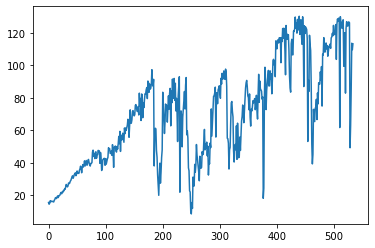

In [16]:
import matplotlib.pyplot as plt
t = eval_list + eval_list_2 + eval_list_3 + eval_list_4
plt.plot(t)

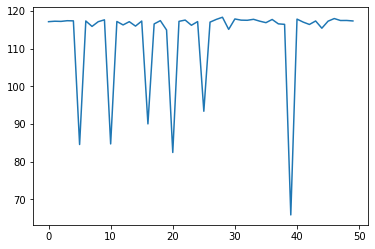

In [25]:
test_kwargs_sequences = [get_const_task_sequence(0.25, 1, 1)[1]]
result_all = agent.meta_test(test_kwargs_sequences, num_test_processes, env_name, seed, ".")
plt.plot(result_all[0])

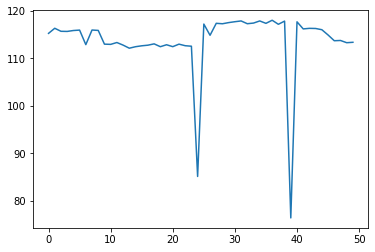

In [26]:
test_kwargs_sequences = [get_linear_task_sequence(0.25, 1, 1)[1]]
result_all = agent.meta_test(test_kwargs_sequences, num_test_processes, env_name, seed, ".")
plt.plot(result_all[0])

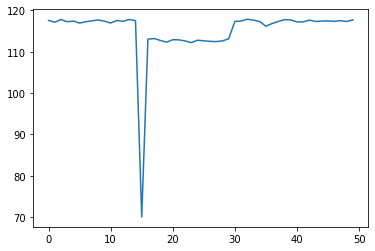

In [27]:
test_kwargs_sequences = [get_phase_task_sequence(0.25, 1, 1)[1]]
result_all = agent.meta_test(test_kwargs_sequences, num_test_processes, env_name, seed, ".")
plt.plot(result_all[0])

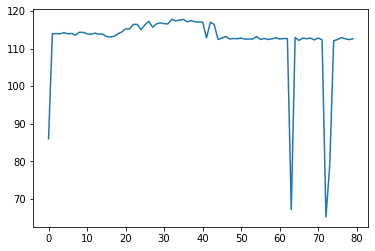

In [28]:
test_kwargs_sequences = [get_abrupt_and_smooth(0.25, 1, 1)[1]]
result_all = agent.meta_test(test_kwargs_sequences, num_test_processes, env_name, seed, ".")
plt.plot(result_all[0])